In [1]:
import os
import json
import requests
import time
import sys
import shutil

import glob
import pickle
import torch
import safetensors.torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd


In [2]:
prefixs = [ "LoRA_Trigger", "LoRA_noTrigger", "noLoRA_Trigger", "noLoRA_noTrigger", 'SpaceShip', 'ComplexImg']



In [3]:

trigger_prompt = "zzMimikyu, solo, pokemon (creature), no humans, animal focus, mimikyu, "
object_prompt = "A cute white rat sitting on a tiny wooden chair, holding a piece of cheese with both hands, wearing a tiny red scarf, big shiny eyes, soft fluffy fur, in a cozy rustic kitchen with warm lighting, soft shadows, shallow depth of field, high detail, 4K resolution, Pixar-style, highly detailed, cinematic lighting, adorable expression"

In [4]:
class Config:
    def __init__(self, model, LoRA, input_image, trigger_prompt, object_prompt, file_prefix, total_steps, current_step):
        self.model = model
        self.LoRA = LoRA
        self.input_image = input_image
        self.trigger_prompt = trigger_prompt
        self.object_prompt = object_prompt
        self.short_object_prompt = object_prompt.split(",")[0].strip()[0:20]
        self.file_prefix = file_prefix
        self.total_steps = total_steps
        self.current_step = current_step

    def add_step(self):
        self.current_step += 1

    def set_input_image(self, input_image):
        self.input_image = input_image

config = Config(
    model="sd_xl_base_1.0.safetensors",
    LoRA="Mimikyu_Pokemon_PDXL.safetensors",
    input_image="input_image.png",
    trigger_prompt=trigger_prompt,
    object_prompt=object_prompt,
    file_prefix=prefixs,
    total_steps=20,
    current_step=0
)

In [5]:
experiment_data = {}
# load experiment data
with open('experiment_data.pkl', 'rb') as f:
    experiment_data = pickle.load(f)
    

In [15]:
print(experiment_data.keys())
print(experiment_data['ComplexImg'].keys())
print(experiment_data['ComplexImg']['A cute white rat sit'].keys())
print(experiment_data['ComplexImg']['A cute white rat sit']['ComplexImg_0.png'].keys())
print(experiment_data['ComplexImg']['A cute white rat sit']['ComplexImg_0.png']['hspace'].shape)

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_0.png', 'ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])
dict_keys(['hspace', 'image', 'latent'])
(19, 2, 1280, 8, 8)


Original data shape: (1280, 8, 8)
Reshaped data for PCA: (1280, 64)
Data after PCA reduction: (1280, 1)
Explained variance ratio: 0.1230


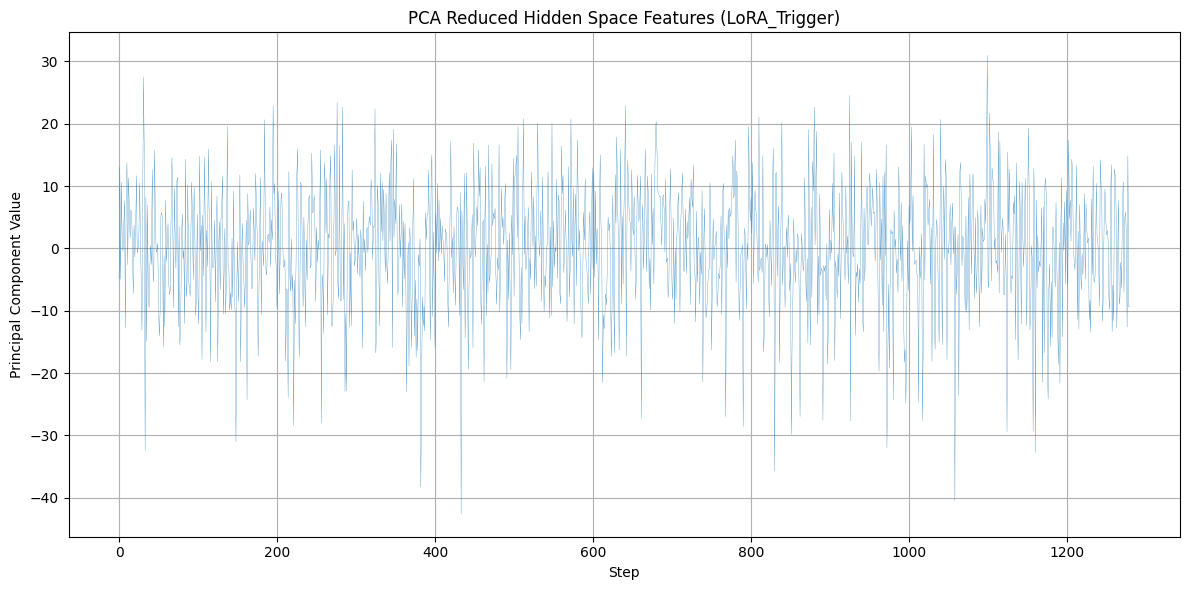

In [13]:
# 將 experiment_data['LoRA_Trigger']['A cute white rat sit']['LoRA_Trigger_0.png']['hspace'] shape= (19, 2, 1280, 8, 8) PCA 降維成一維，然後畫成折線圖

# Import necessary library for PCA
from sklearn.decomposition import PCA

# Extract the data
hspace_data = experiment_data['LoRA_Trigger']['A cute white rat sit']['LoRA_Trigger_0.png']['hspace'][15][1]
print("Original data shape:", hspace_data.shape)

# Reshape the data to 2D for PCA (samples x features)
# Combine all dimensions except the first one
n_samples = hspace_data.shape[0]  # 19 steps
n_features = np.prod(hspace_data.shape[1:])  # 2*1280*8*8 features
reshaped_data = hspace_data.reshape(n_samples, n_features)
print("Reshaped data for PCA:", reshaped_data.shape)

# Apply PCA to reduce to 1 dimension
pca = PCA(n_components=1)
reduced_data = pca.fit_transform(reshaped_data)
print("Data after PCA reduction:", reduced_data.shape)
print(f"Explained variance ratio: {pca.explained_variance_ratio_[0]:.4f}")

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(range(len(reduced_data)), reduced_data, linestyle='-', linewidth=0.2)
plt.title('PCA Reduced Hidden Space Features (LoRA_Trigger)')
plt.xlabel('Step')
plt.ylabel('Principal Component Value')
plt.grid(True)
plt.tight_layout()
plt.show()


Original data shape: (1280, 8, 8)
Reshaped data for PCA: (1280, 64)
Data after PCA reduction: (1280, 1)
Explained variance ratio: 0.2003


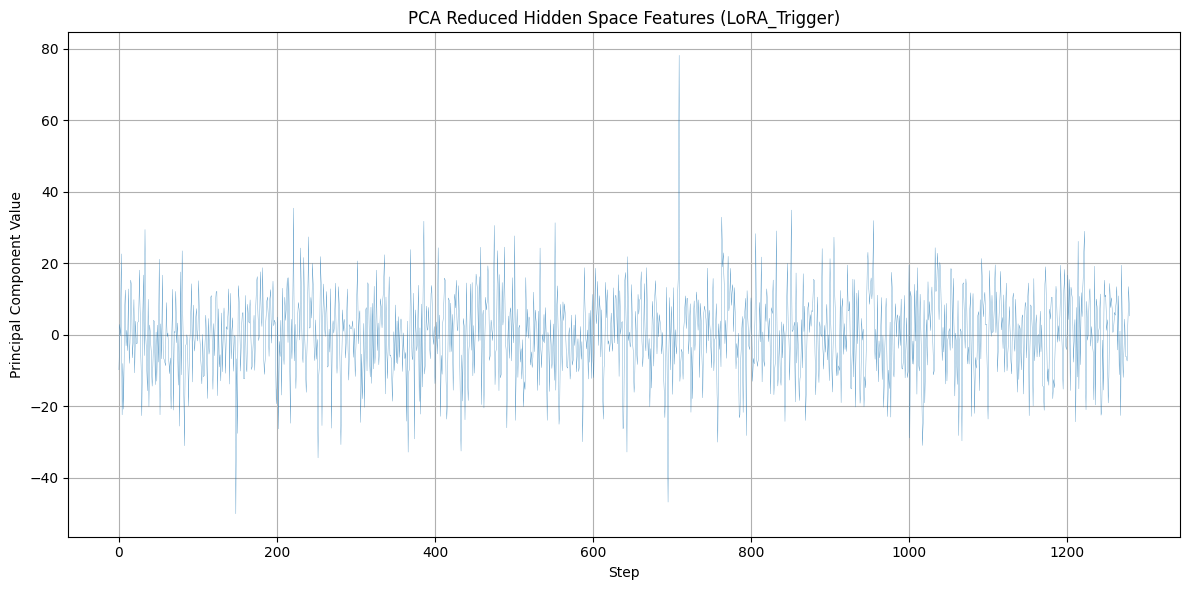

In [16]:
# 將 experiment_data['LoRA_Trigger']['A cute white rat sit']['LoRA_Trigger_0.png']['hspace'] shape= (19, 2, 1280, 8, 8) PCA 降維成一維，然後畫成折線圖

# Import necessary library for PCA
from sklearn.decomposition import PCA

# Extract the data
hspace_data = experiment_data['ComplexImg']['A cute white rat sit']['ComplexImg_0.png']['hspace'][15][1]
print("Original data shape:", hspace_data.shape)

# Reshape the data to 2D for PCA (samples x features)
# Combine all dimensions except the first one
n_samples = hspace_data.shape[0]  # 19 steps
n_features = np.prod(hspace_data.shape[1:])  # 2*1280*8*8 features
reshaped_data = hspace_data.reshape(n_samples, n_features)
print("Reshaped data for PCA:", reshaped_data.shape)

# Apply PCA to reduce to 1 dimension
pca = PCA(n_components=1)
reduced_data = pca.fit_transform(reshaped_data)
print("Data after PCA reduction:", reduced_data.shape)
print(f"Explained variance ratio: {pca.explained_variance_ratio_[0]:.4f}")

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(range(len(reduced_data)), reduced_data, linestyle='-', linewidth=0.2)
plt.title('PCA Reduced Hidden Space Features (LoRA_Trigger)')
plt.xlabel('Step')
plt.ylabel('Principal Component Value')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
experiment_data['LoRA_Trigger']['A cute white rat sit']['LoRA_Trigger_0.png']['hspace'][15][1] == experiment_data['LoRA_Trigger']['A cute white rat sit']['LoRA_Trigger_0.png']['hspace'][15][0]

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [8]:
# Extract the data
hspace_data = experiment_data['LoRA_Trigger']['A cute white rat sit']['LoRA_Trigger_0.png']['hspace']

# Reshape the data into a 2D array
reshaped_data = hspace_data.reshape(-1, hspace_data.shape[-1])

# Create a pandas DataFrame
df_hspace = pd.DataFrame(reshaped_data)

# Display the DataFrame
print(df_hspace)

               0         1         2         3         4         5         6  \
0      -5.690822 -3.685240 -2.186050 -0.547795 -1.209764 -2.549928 -2.926405   
1      -2.579921 -4.309063 -4.202701 -2.500562 -3.594195 -4.475212 -4.190843   
2      -4.361973 -5.909978 -6.148072 -5.287431 -5.165095 -2.815290 -3.828193   
3      -4.389589 -6.411722 -7.591676 -7.764853 -6.625418 -3.207011 -6.344969   
4      -3.407074 -6.875288 -6.666673 -5.016933 -5.734756 -2.410320 -6.509775   
...          ...       ...       ...       ...       ...       ...       ...   
389115 -2.603475  0.497803  0.439205 -5.087639 -0.891228 -0.701027 -0.422589   
389116 -2.474116 -2.186555 -3.961016 -0.508560 -5.658172 -2.330665 -1.120443   
389117  1.089751 -1.264450 -4.914359  0.319673 -0.559665 -3.309718 -3.662570   
389118 -3.917111 -7.370612 -9.880714 -1.717651 -0.464810 -3.553703  0.888052   
389119  1.869466  1.989015  0.476007  2.996447  9.180073  5.074569  0.548445   

               7  
0      -3.608446  
1

c:\Users\9373k\miniconda3\envs\comfy\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


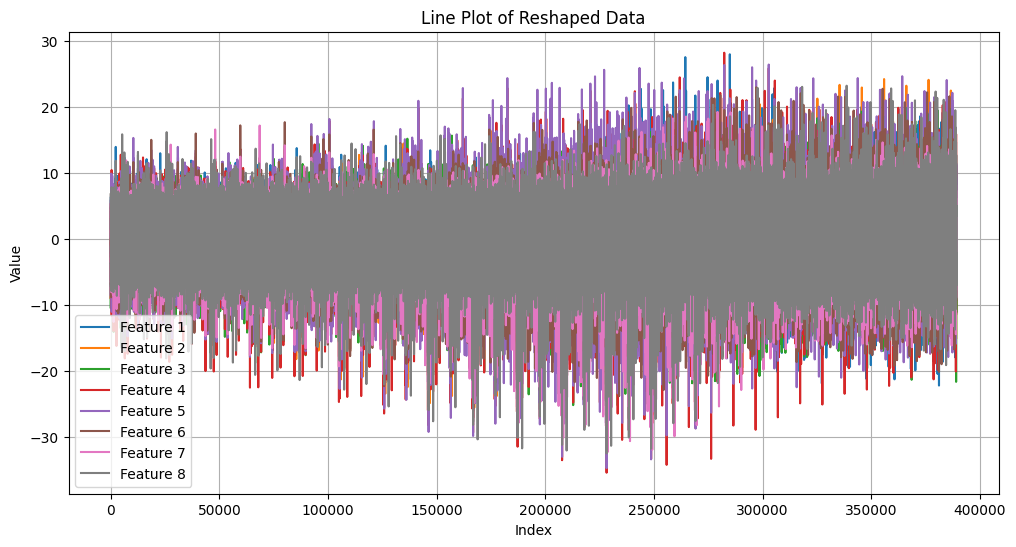

In [9]:
# experiment_data['LoRA_Trigger']['A cute white rat sit']['LoRA_Trigger_0.png']['hspace'] (19, 2, 1280, 8, 8) 降維成一維，然後畫成折線圖
# Convert reshaped_data into a pandas DataFrame for easier manipulation
df_lineplot = pd.DataFrame(reshaped_data)

# Plot the data as a line plot
plt.figure(figsize=(12, 6))
for i in range(df_lineplot.shape[1]):  # Iterate over each column
    plt.plot(df_lineplot.index, df_lineplot[i], label=f'Feature {i+1}')

plt.title('Line Plot of Reshaped Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

